<a href="https://colab.research.google.com/github/Jedi80/21-Projects-in-21-Days-Projects-AI-ML-and-Data-Science/blob/main/16_Intelligent_Document_Automation_Building_a_Smart_OCR_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Comprehension of Intelligent Document Processing

Intelligent Document Processing (IDP) is an advanced automation technology that transforms the way businesses handle documents. By leveraging artificial intelligence (AI), IDP systems can automatically read, understand, and process vast quantities of documents, extracting crucial data and feeding it into various business workflows. This technology is a significant leap from traditional Optical Character Recognition (OCR) as it not only digitizes text but also comprehends the context and structure of the information within documents.

At its core, IDP is designed to tackle the challenge of processing unstructured and semi-structured data, which make up a large portion of business documents such as invoices, contracts, emails, and forms. By automating the extraction and interpretation of this data, IDP significantly reduces the need for manual data entry, leading to increased efficiency, higher accuracy, and substantial cost savings.

<br><br>

---
<br><br>

### The Inner Workings of Intelligent Document Processing

The power of IDP lies in its sophisticated multi-step process that intelligently handles documents from ingestion to data delivery. This process typically involves several key stages:

**1. Document Ingestion:** The first step involves importing documents from various sources and in multiple formats, including scanned paper documents, PDFs, Word files, and images.

**2. Pre-processing:** To enhance the quality of the input, documents undergo a pre-processing stage. This includes techniques like noise reduction, image enhancement, and deskewing to improve the accuracy of subsequent data extraction.

**3. Document Classification:** Using machine learning algorithms, the IDP system automatically categorizes documents based on their layout and content. This allows the system to differentiate between an invoice, a purchase order, or a legal contract, for instance.

**4. Data Extraction:** This is the core function of IDP. Advanced AI technologies, including Natural Language Processing (NLP) and computer vision, are employed to identify and extract relevant data fields. For example, from an invoice, it can pull out the invoice number, date, vendor name, and line-item details.

**5. Data Validation:** The extracted data is then validated against predefined rules and existing databases to ensure accuracy and consistency. Any exceptions or discrepancies can be flagged for human review in a "human-in-the-loop" process, which also helps to train and improve the AI model over time.

**6. Integration:** Finally, the structured and validated data is seamlessly integrated into downstream business systems such as Enterprise Resource Planning (ERP), Customer Relationship Management (CRM), or other databases, making the information readily available for further processing and analysis.


From **finance departments** automating invoice processing and expense management to **healthcare organizations** streamlining patient record management and claims processing, IDP is proving to be a game-changer. Even  **human resources** can expedite resume screening and employee onboarding. As the technology continues to evolve, its applications are expected to expand even further, solidifying its role as a cornerstone of modern digital transformation.

# Our Approach

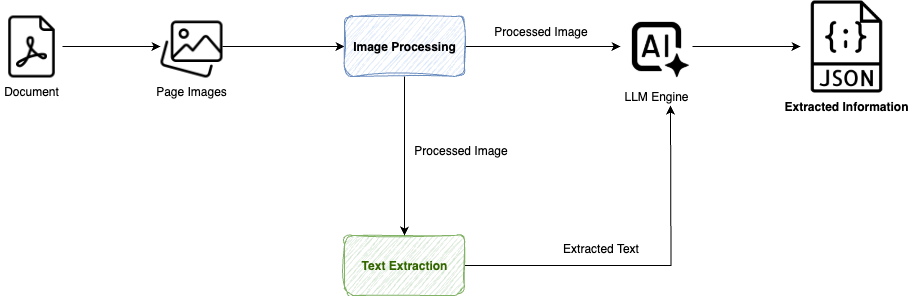

# SROIEv2: The Receipts Dataset

## Getting the data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("urbikn/sroie-datasetv2")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sroie-datasetv2' dataset.
Path to dataset files: /kaggle/input/sroie-datasetv2


In [ ]:
! cat /kaggle/input/sroie-datasetv2/SROIE2019/test/entities/X00016469670.txt

{
    "company": "OJC MARKETING SDN BHD",
    "date": "15/01/2019",
    "address": "NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, B1750 MASAI, JOHOR",
    "total": "193.00"
}

Since these are single-paged images already, we don't need to convert them

## Understanding the data


The downloaded dataset contains two major folders:
1. **train**: This folder contains the training data.
2. **test**: This folder contains the test data.

Each of these folders contains the following subfolders:
1. **img**: This folder containing the images of the receipts.
2. **box**: This folder containing the bounding box information of the text in the images and the text inside the bounding boxes. The file is a text file with the same name as the image file but with a .txt extension. The format of the file is as follows:
    ```
    x1, y1, x2, y2, x3, y3, x4, y4, text
    ```
    where (x1, y1), (x2, y2), (x3, y3), and (x4, y4) are the coordinates of the bounding box and text is the text inside the bounding box.
3. **entities**: This folder contains the ground truth information of the entities in the receipts. The file is a text file with the same name as the image file but with a .txt extension. The file contains json data with the following format:
    ```json
    {
        "company": "COMPANY_NAME",
        "date": "DATE",
        "address": "ADDRESS",
        "total": "TOTAL",
    }
    ```

## Image Preprocesing: OpenCV

In [ ]:
! pip install opencv-python matplotlib numpy

Let's take one image and play with it.

In [ ]:
import os
one_image_path = os.path.join(path, 'SROIE2019', 'train', 'img', 'X51005453729.jpg')

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_image(image, title="Image"):
    plt.figure(figsize=(10, 10)) # Increased figure size here
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

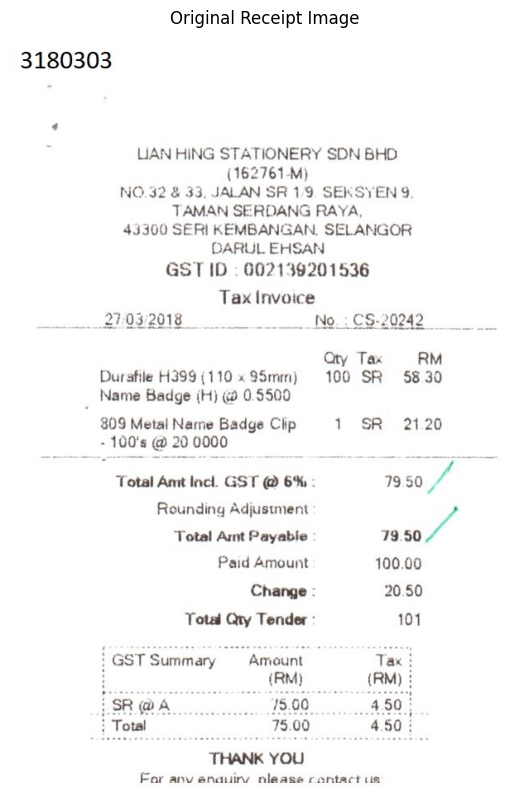

In [ ]:
one_image = cv2.imread(one_image_path)
display_image(one_image, "Original Receipt Image")

### Grayscale Conversion

**Why?** Color information is usually not necessary for reading the text on a receipt. Converting the image to grayscale simplifies it from three color channels (Red, Green, Blue) to a single channel (intensity/brightness). This reduces computational complexity and is a required first step for many subsequent operations like thresholding.

In [ ]:
# Convert the image to grayscale
def convert_to_grayscale(image):
  if image.ndim == 3:
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image

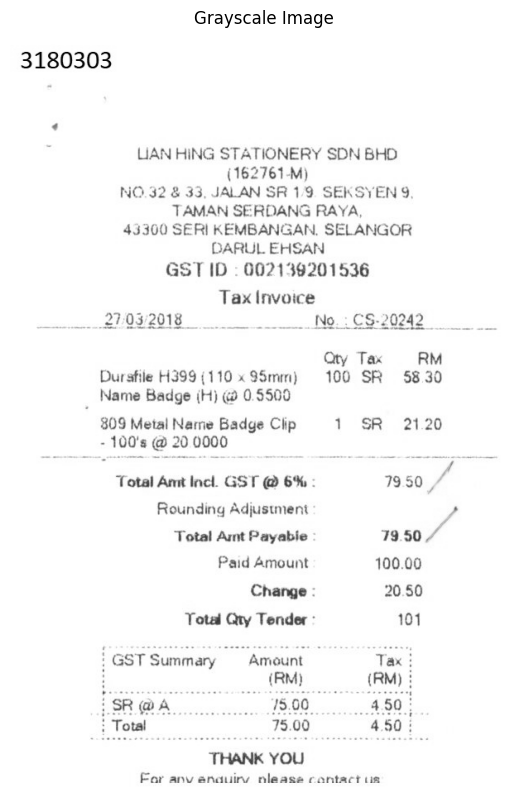

In [ ]:
grayscale_image = convert_to_grayscale(one_image)
display_image(grayscale_image, "Grayscale Image")

### Noise (blur) Reduction
**Why?** Scanned images or photos often contain "noise" (random variations in brightness or color). This can look like small specks or graininess, which can confuse OCR algorithms. Applying a slight blur helps to smooth out this noise. A **Gaussian blur** is a common choice as it effectively averages out pixel values with a weighted average, preserving edges better than a simple blur.

In [ ]:
def reduce_noise(gray_image):
  return cv2.GaussianBlur(gray_image, (5, 5), 0)

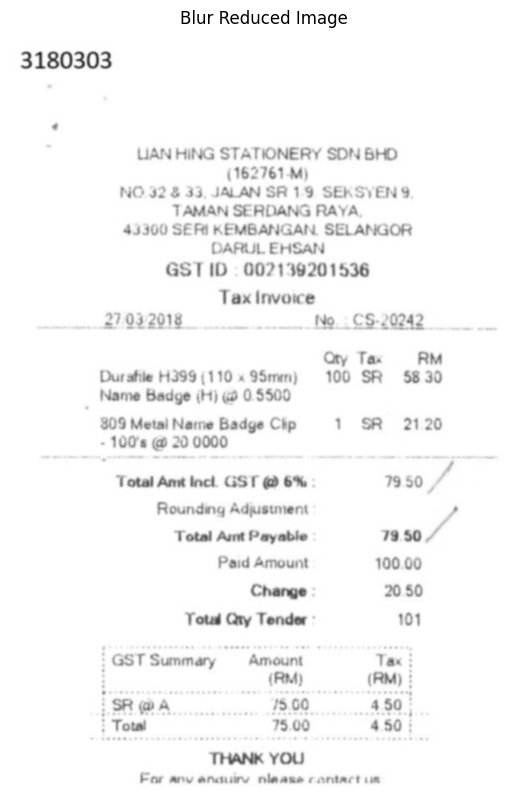

In [ ]:
blur_reduced_image = reduce_noise(grayscale_image)
display_image(blur_reduced_image, "Blur Reduced Image")

### Binarization (Thresholding)

**Why?** This is one of the most critical steps. Binarization converts the grayscale image into a pure black-and-white image. The goal is to make the text **black** and the background **white**. However, receipts often have uneven lighting or shadows, so a simple (global) threshold won't work well. We use **adaptive thresholding**, which calculates a different threshold for smaller regions of the image, making it robust to lighting changes.

`cv2.adaptiveThreshold()`:

  * `cv2.ADAPTIVE_THRESH_GAUSSIAN_C`: Calculates the threshold for a pixel based on a weighted sum of neighborhood values.
  * `cv2.THRESH_BINARY_INV`: Inverts the result. We want the text to be white pixels (value 255) and the background black (value 0) for the next step (skew correction), which often works by finding white pixel contours.
  * `11`: The size of the neighborhood area (block size).
  * `4`: A constant subtracted from the mean. It's a fine-tuning parameter.

In [ ]:
def binarize_image(blur_reduced_image):
  return cv2.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, # Invert the colors (text becomes white because of matplotlib)
    11, # Block size
    4  # Constant C
  )

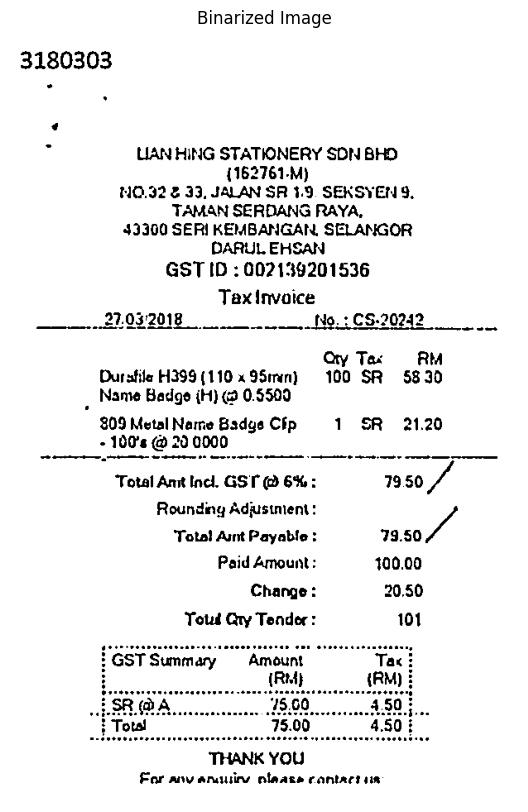

In [ ]:
binarized_image = binarize_image(blur_reduced_image)
display_image(binarized_image, "Binarized Image")

### Skew Correction

**Why?** Receipts are often scanned or photographed at a slight angle. This skew can significantly reduce the accuracy of OCR. We need to detect this angle and rotate the image to make the text perfectly horizontal.

A common technique is to find the angle of the minimum-area bounding box that encloses all the text (the white pixels in our binarized image) and then rotate the original image by that angle.

In [ ]:
def deskew_image(image):
    """
    Corrects the skew of an image by finding the minimum area rectangle
    of the text block and rotating accordingly.
    """
    # Find all non-zero (white) pixels
    coords = cv2.findNonZero(image)

    # Get the minimum area bounding rectangle
    # It returns (center(x,y), (width, height), angle of rotation)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1] - 90

    # The `cv2.minAreaRect` angle has a specific range.
    # We need to adjust it for our rotation.
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = angle

    # Get the rotation matrix and rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    # print(f"Detected skew angle: {angle:.2f} degrees")

    # Now, rotate the original grayscale image by the same angle
    (h, w) = rotated.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_gray = cv2.warpAffine(rotated, M, (w, h),
                                  flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)

    return deskewed_gray

In [ ]:
deskewed_image = deskew_image(binarized_image)

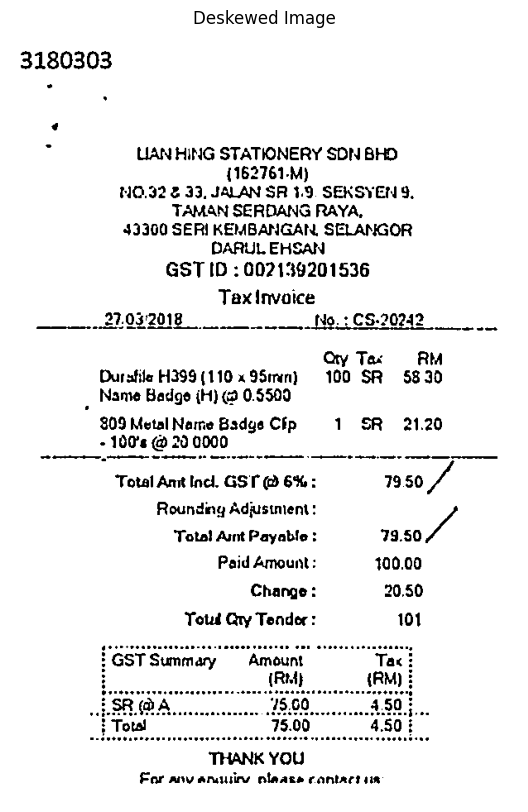

In [ ]:
display_image(deskewed_image, "Deskewed Image")

Let's run the above code for all images

In [ ]:
os.path.join(path, 'SROIE2019', 'train', 'img', 'X51007231344.jpg')

'/kaggle/input/sroie-datasetv2/SROIE2019/train/img/X51007231344.jpg'

In [ ]:
def process_one_image(image):
  image = convert_to_grayscale(image)
  # print("Converted image to grayscale..")
  image = reduce_noise(image)
  # print("Reduced noise in the image..")
  image = binarize_image(image)
  # print("Binarized the image..")
  image = deskew_image(image)
  # print("Corrected image orientation..")
  return image

In [ ]:
import time
from tqdm.auto import tqdm

output_folder_path = "/content/processed_images"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

# Sorting the list of images in the dataset we're working with
# so that the code will pull the same images files each time

# Get a list of all files in the folder
path_to_images = os.path.join(path, 'SROIE2019', 'train', 'img')

all_files = os.listdir(path_to_images)

# Sort the files (optional, but ensures consistent top 20 files)
all_files.sort()

print(f"Files targeted for processing (first 20 after sorting): {all_files[:20]}")

#os.listdir() pulls files arbitrarily, which was a problem alter
#for image_name in tqdm(os.listdir(os.path.join(path, 'SROIE2019', 'train', 'img'))[:20]):

for image_name in tqdm(all_files[:20]): # MODIFIED: Use the sorted 'all_files' list


  # print(f"Processing image: {image_name}")
  image_path = os.path.join(path, 'SROIE2019', 'train', 'img', image_name)


  image = cv2.imread(image_path)

  processed_image = process_one_image(image)

  # save image
  output_path = os.path.join(output_folder_path, image_name)

  cv2.imwrite(output_path, processed_image)

  # print(f"Saved processed image to: {output_path}")
  # print("-"*50)

print("Processing images is completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Files targeted for processing (first 20 after sorting): ['X00016469612.jpg', 'X00016469619.jpg', 'X00016469620.jpg', 'X00016469622.jpg', 'X00016469623.jpg', 'X00016469669.jpg', 'X00016469672.jpg', 'X00016469676.jpg', 'X51005200938.jpg', 'X51005230617.jpg', 'X51005255805.jpg', 'X51005268200.jpg', 'X51005268262.jpg', 'X51005268400.jpg', 'X51005268472.jpg', 'X51005301659.jpg', 'X51005301661.jpg', 'X51005301667.jpg', 'X51005303661.jpg', 'X51005306399.jpg']


  0%|          | 0/20 [00:00<?, ?it/s]

Processing images is completed.
Total time taken: 6.689605712890625 seconds


## Text Extraction: Tesseract

Tesseract OCR is a powerful and widely-used open-source optical character recognition (OCR) engine. In simple terms, it's a software that can "read" text from images and convert it into machine-readable text. This means you can take a picture of a document, a sign, or any other object containing text, and Tesseract can extract that text so you can edit, search, or analyze it.

### A Brief History and Development

Originally developed by Hewlett-Packard in the 1980s, Tesseract was later open-sourced in 2005 and has been sponsored by Google since 2006. This has led to significant improvements and made it one of the most accurate and versatile free OCR engines available. The latest versions of Tesseract utilize long short-term memory (LSTM), a type of recurrent neural network (RNN), which has greatly enhanced its ability to recognize text with high accuracy.



### Core Functionalities and Capabilities

Tesseract boasts a rich set of features that make it a flexible tool for various applications:

  * **Extensive Language Support:** Tesseract can recognize over 100 languages, making it a truly global OCR solution. It also supports multiple scripts and can even be trained to recognize new languages.
  * **Multiple Output Formats:** It can output the recognized text in various formats, including plain text, HTML, PDF, and TSV (tab-separated values). This allows for easy integration with other software and workflows.
  * **Page Segmentation Modes:** Tesseract offers different page segmentation modes, which help in correctly identifying the layout of a document, including columns, paragraphs, and blocks of text.
  * **Character Recognition and Confidence:** Not only does it recognize characters, but it can also provide a confidence score for each recognized character, word, or line. This is useful for assessing the accuracy of the OCR process.
  * **Command-Line and API Access:** Tesseract can be used as a command-line tool for quick and simple OCR tasks. For more complex integrations, it provides an API that allows developers to incorporate its OCR capabilities into their own applications. Popular wrappers like Pytesseract make it easy to use Tesseract with programming languages like Python.


### Installation
`pip install pytesseract pillow`


### How to Use Tesseract

For developers, integrating Tesseract into an application is straightforward using its API. Here is a simple example using the `pytesseract` wrapper in Python:

```python

from PIL import Image
import pytesseract


text = pytesseract.image_to_string(Image.open(filename))

print(text)
```



### Common Use Cases and Applications

The ability to extract text from images opens up a vast range of applications across various industries:

  * **Document Digitization:** Converting scanned documents, books, and historical archives into searchable digital text.
  * **Data Entry Automation:** Automating the process of entering data from invoices, receipts, and forms.
  * **Accessibility:** Assisting visually impaired individuals by converting printed text into speech.
  * **License Plate Recognition:** In law enforcement and traffic management systems.
  * **Social Media Monitoring:** Analyzing text within images shared on social media platforms.
  * **Translation:** Extracting text from an image and then using a translation service to translate it.

While Tesseract is a powerful tool, the accuracy of its output heavily depends on the quality of the input image. For best results, images should be clear, well-lit, and have a high resolution. Pre-processing steps like resizing, noise reduction, and converting to grayscale can significantly improve OCR accuracy.

In [ ]:
! pip install pytesseract pillow

In [ ]:
from PIL import Image
import pytesseract
import os

# The specific file name causing the error
file_to_check = '/content/processed_images/X51005200938.jpg'

# Check if the file exists before attempting to open it
if os.path.exists(file_to_check):
    print(f"File '{file_to_check}' found. Attempting to extract text...")
    # Use pytesseract to extract text
    extracted_text = pytesseract.image_to_string(Image.open(file_to_check))
    print(extracted_text)
else:
    print(f"Error: File '{file_to_check}' not found in the specified directory.")
    print("Please ensure the image processing cell (pL8hhsuENS29) has been run successfully to create this file.")
    print(f"Contents of '/content/processed_images/': {os.listdir('/content/processed_images/')}")

# from PIL import Image
# import pytesseract

# print(pytesseract.image_to_string(Image.open('/content/processed_images/X51005200938.jpg')))

File '/content/processed_images/X51005200938.jpg' found. Attempting to extract text...
Anrodss

PERNIAGAAN ZHENG HU)
RES
NO.69 JALAN PERBAS QS
BANDAR BARU PERMAS JAVA
81760 JOHOR BAHRU
‘TEL:07-288 7525 FAX 207.386.3783

OST NO: 09080050826

SIMPLIFIED TAX INVOICE
“GOGUHTENGINEERING (MjSONEND
“Rezelpla. CS0MaDES —

 

 

Salesporsees Date: 12022018
Castles: USER ‘rme:08.3990

, “Ry (RM
fan RSP_ Amount
8239 GB 1 00 10K

‘SR: 11* PROWESS H/DUTY BILICONE GUN G-02
OSSC07S 100147 Gh 3 7.00 2100
‘SR: XTRASEAL RIV ACETIC SRICONE SA-107

 

 

o7ee GBo1 1800 tke
SR CENTRAL PUNCH SET PCS 14,522.18"
12525 GG 1 §000 sae
SR, 24" MARKSMAN PIPE WRENCH
2016 GA 3 020 att
SR: PYGWMIRE TAPE 1PCX 7D. ;
Ora Ft
(ExtLeedGST) So To'at(AM) : 106.10
Olscoun (RM) : 00
Total GST (RM) : 637
Rounding (RM) : 0.02
Fotal(Rtay : 142.46
CASH : 412.48
Change (RM) : 0,00
GST SUMMARY

TaxCode Amount Gast
Sk 6 706.10 6.37

— 63

Tefal: 106.10

GOOOS SOLO ARE NOT RETURNABLE,
THANK YOU,



In [ ]:
from PIL import Image
import pytesseract
import time

input_folder_path = "/content/processed_images"
output_folder_path = "/content/tesseract_output"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(input_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print("Extracting text from image..")
  text = pytesseract.image_to_string(Image.open(image_path))
  output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".txt"))
  with open(output_path, "w") as f:
    f.write(text)

  print(f"Saved extracted text to {output_path}")
  print("-"*50)

print("Text Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 20
Processing image 1/20: X00016469676.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X00016469676.txt
--------------------------------------------------
Processing image 2/20: X00016469612.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X00016469612.txt
--------------------------------------------------
Processing image 3/20: X51005303661.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51005303661.txt
--------------------------------------------------
Processing image 4/20: X00016469622.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X00016469622.txt
--------------------------------------------------
Processing image 5/20: X51005200938.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51005200938.txt
--------------------------------------------------
Processing image 6/20: X51005268472.jp

## Information Extraction

In [ ]:
prompt = """
Extract the information from the given image.
Information to be extracted: company, date, address, total.
The image has been converted to grayscale, noise reduced, binarized, and deskewed using opencv.
Always give your response in the following format:
{
    "company": "COMPANY_NAME",
    "date": "DATE",
    "address": "ADDRESS",
    "total": "TOTAL",
}
Also, the text has been extracted from the image using tesseract.
Use the extracted text as support for extracting information.
If you believe the text extraction is incorrect somewhere, you may correct it yourself and provide corrected information.
Respond with the extracted information only in the specified format.
Here is the text:


"""

Can we improve the prompt using the [Unified Framework For An Effective Prompt](https://www.geeksforgeeks.org/data-science/a-unified-framework-for-an-effective-prompt/)?

In [ ]:
from google import genai
from google.colab import userdata # colab only code
from PIL import Image
import json
import time

In [ ]:
genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

The following code from the lecture is commented out, because it takes a while to run and calls the Gemini API, which can only be called around 20 times a day before the rate limit is reached.

In [ ]:
# image_folder_path = "/content/processed_images"
# text_folder_path = "/content/tesseract_output"
# output_folder_path = "/content/json_output"

# start_time = time.time()

# if os.makedirs(output_folder_path, exist_ok=True):
#   print(f"Created folder: {output_folder_path}")

# total_images = sum(1 for entry in os.scandir(image_folder_path))
# print(f"Total images in folder: {total_images}")

# for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):

#   print(f"Processing image {i}/{total_images}: {image_name}")

#   image_path = os.path.join(input_folder_path, image_name)

#   print(f"Loading image: {image_path}")
#   with open(image_path, "rb") as f:
#     image = Image.open(image_path)
#     # print(image)


#   text_path = os.path.join(text_folder_path, image_name.replace(".jpg", ".txt"))

#   print(f"Loading extracted text: {text_path}")
#   with open(text_path, "r") as f:
#     text = f.read()

#   print("Extracting information from image and text..")

#   prompt = prompt + text



#   contents = [
#         image,
#         {
#             "text": prompt
#         }
#     ]
#   response = genai_client.models.generate_content(model='gemini-2.5-flash', contents=contents)

#   # Access the usage_metadata attribute

#   usage_metadata = response.usage_metadata

#   # Print the different token counts
#   print(f"Input Token Count: {usage_metadata.prompt_token_count}")
#   print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
#   print(f"Output Token Count: {usage_metadata.candidates_token_count}")
#   print(f"Total Token Count: {usage_metadata.total_token_count}")

#   extracted_information = json.loads(response.text.replace('```json', '').replace('```', ''))

#   output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".json"))
#   with open(output_path, "w") as f:
#     json.dump(extracted_information, f, indent=4)

#   print(f"Saved extracted information to {output_path}")
#   print("-"*50)
#   time.sleep(60)

# print("Information Extraction Completed.")
# print(f"Total time taken: {time.time() - start_time} seconds")

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Can you play with a Resume Dataset?

https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset

##Project 16 Submission
Using the above accountant data in the resume-dataset to test out above document/image processing techniques. Using the FITNESS dataset to extract information, since the pdfs are already clear.

**Explaining the Following Code Cell **

I had some issues with getting the resume-dataset to appear in the /kaggle/input folder. While I learned that the data set is still saved to the cache location via the 'path' variable, I still wanted to be able to access the dataset to view the pdfs from the kaggle folder in Google Colab, hence part of the code cell checking if the kaggle directory in Colab has the dataset after the code ran.

In [ ]:
import kagglehub
import time
import os

# Define path globally so other cells can access it.
# This 'path' usually points to the cache location (e.g., /root/.cache/kagglehub/...)
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

print("Path to dataset files (cache location):", path)

# Define the expected location of the dataset within /kaggle/input/
# This is where Colab typically symlinks Kaggle datasets.
expected_subdir_in_kaggle_input = os.path.join(path, 'data', 'data')

# Verify if the expected directory within /kaggle/input/ exists and contains items
if not os.path.exists(expected_subdir_in_kaggle_input) or not os.listdir(expected_subdir_in_kaggle_input):
    print(f"Warning: Expected directory in /kaggle/input: '{expected_subdir_in_kaggle_input}' not found or is empty.")
    print("Attempting to re-download/re-link the dataset to ensure accessibility in /kaggle/input/...")
    # Re-run the download. This should refresh symlinks to /kaggle/input if they were broken.
    path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

    if os.path.exists(expected_subdir_in_kaggle_input) and os.listdir(expected_subdir_in_kaggle_input):
        print("Dataset now appears to be correctly linked/downloaded in /kaggle/input/.")
    else:
        print("Error: Dataset still not correctly linked/downloaded in /kaggle/input/ after retry. Please check KaggleHub status or try running this cell again manually.")
else:
    print(f"Confirmation: Directory '{expected_subdir_in_kaggle_input}' in /kaggle/input/ exists and is not empty.")



Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to dataset files (cache location): /kaggle/input/resume-dataset
Confirmation: Directory '/kaggle/input/resume-dataset/data/data' in /kaggle/input/ exists and is not empty.


###Experimenting with a single resume

In [ ]:
import os
one_resume_path = os.path.join(path, 'data', 'data', 'ACCOUNTANT', '10554236.pdf')

In [ ]:
!pip install PyMuPDF Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 111.1 MB/s eta 0:00:00


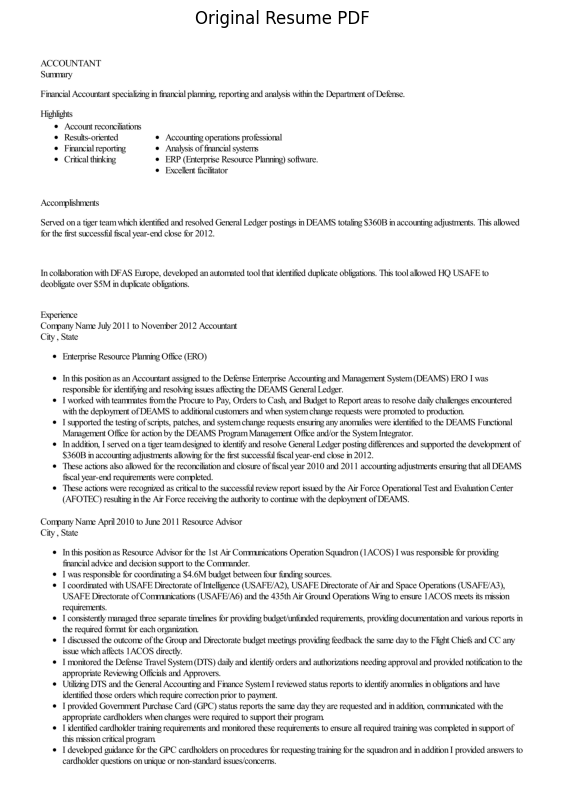

In [ ]:
import pymupdf # Updated import statement

# Open the PDF file
doc = pymupdf.open(one_resume_path)

# Get the first page
page = doc[0]

# Render page to an image (pixmap) with increased resolution
# By default, get_pixmap renders at 72 DPI. Scaling by 32.0 effectively multiplies the DPI by 32.
scale = 4.0 # Increased scale value to produce a higher resolution image
pix = page.get_pixmap(matrix=pymupdf.Matrix(scale, scale))

# Convert pixmap to numpy array
one_image = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)

# Close the document
doc.close()

display_image(one_image, "Original Resume PDF")

In [ ]:
import cv2
import numpy as np

def sharpen_image(image):
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel)

def reduce_noise(gray_image):
  return cv2.GaussianBlur(gray_image, (5, 5), 0)

`cv2.adaptiveThreshold()`:

  * `cv2.ADAPTIVE_THRESH_GAUSSIAN_C`: Calculates the threshold for a pixel based on a weighted sum of neighborhood values.
  * `cv2.THRESH_BINARY_INV`: Inverts the result. We want the text to be white pixels (value 255) and the background black (value 0) for the next step (skew correction), which often works by finding white pixel contours.
  * `11`: The size of the neighborhood area (block size).
  * `4`: A constant subtracted from the mean. It's a fine-tuning parameter.

In [ ]:
def binarize_image(blur_reduced_image):
  return cv2.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, # Invert the colors (text becomes white because of matplotlib)
    11, # Block size
    4  # Constant C
  )

In [ ]:
def deskew_image(image):
    """
    Corrects the skew of an image by finding the minimum area rectangle
    of the text block and rotating accordingly.
    """
    # Find all non-zero (white) pixels
    coords = cv2.findNonZero(image)

    # Get the minimum area bounding rectangle
    # It returns (center(x,y), (width, height), angle of rotation)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1] - 90

    # The `cv2.minAreaRect` angle has a specific range.
    # We need to adjust it for our rotation.
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = angle

    # Get the rotation matrix and rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    # print(f"Detected skew angle: {angle:.2f} degrees")

    # Now, rotate the original grayscale image by the same angle
    (h, w) = rotated.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_gray = cv2.warpAffine(rotated, M, (w, h),
                                  flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)

    return deskewed_gray

In [ ]:
def process_and_display_resume_steps(image):
  # 1. Grayscale Conversion
  gray_image = convert_to_grayscale(image)
  display_image(gray_image, "Step 1: Grayscale Image")

  # 2. Noise Reduction (light blur)
  blur_reduced_image = reduce_noise(gray_image)
  display_image(blur_reduced_image, "Step 2: Noise Reduced (Blurred) Image")

  # 3. Sharpening
  sharpened_image = sharpen_image(blur_reduced_image)
  display_image(sharpened_image, "Step 3: Sharpened Image")

  # 4. Binarization (Thresholding)
  binarized_image = binarize_image(sharpened_image)
  display_image(binarized_image, "Step 4: Binarized Image")

  # 5. Skew Correction
  deskewed_image = deskew_image(binarized_image)
  display_image(deskewed_image, "Step 5: Deskewed Image")

  return deskewed_image

In [ ]:
###Use this code cell if you want to do image cleaning on all document pages

# import os
# import time
# from tqdm.auto import tqdm
# import pymupdf # Added import for PyMuPDF here for self-containment

# output_folder_path = "/content/processed_resume_pdfs" # Changed to a new folder
# start_time = time.time()

# # Ensure output folder exists
# if not os.path.exists(output_folder_path):
#   os.makedirs(output_folder_path)
#   print(f"Created folder: {output_folder_path}")

# # Redefine one_resume_path and one_image for self-contained execution
# # This ensures these variables are always available in this cell's scope
# one_resume_path = os.path.join(path, 'data', 'data', 'ACCOUNTANT', '10554236.pdf')

# print(f"Processing resume: {one_resume_path}")

# # Open the PDF file
# doc = pymupdf.open(one_resume_path)

# #for looping through all pages
# for page_num in range(len(doc)):
#   page = doc[page_num]


#   # Render page to an image (pixmap) with increased resolution
#   scale = 8.0 # Changed scale value to 8.0 as requested
#   pix = page.get_pixmap(matrix=pymupdf.Matrix(scale, scale))

#   # Convert pixmap to numpy array
#   one_image = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)

#   print(f"\n--- Processing Page {page_num + 1} ---")

#   # Process the image with individual step visualization
#   processed_resume_image = process_and_display_resume_steps(one_image)

#   # Save the final processed image for this page
#   output_resume_path = os.path.join(output_folder_path, f"processed_resume_10554236_page_{page_num}.jpg")
#   cv2.imwrite(output_resume_path, processed_resume_image)

#   print(f"Saved processed image for Page {page_num + 1} to: {output_resume_path}")
#   display_image(processed_resume_image, f"Final Processed and Deskewed Resume Image - Page {page_num + 1}")


# doc.close()

# print("\nProcessing all resume pages completed.")
# print(f"Total time taken: {time.time() - start_time} seconds")

Created folder: /content/processed_resume_pdfs
Processing resume: /root/.cache/kagglehub/datasets/snehaanbhawal/resume-dataset/versions/1/data/data/ACCOUNTANT/10554236.pdf

--- Processing Page ---


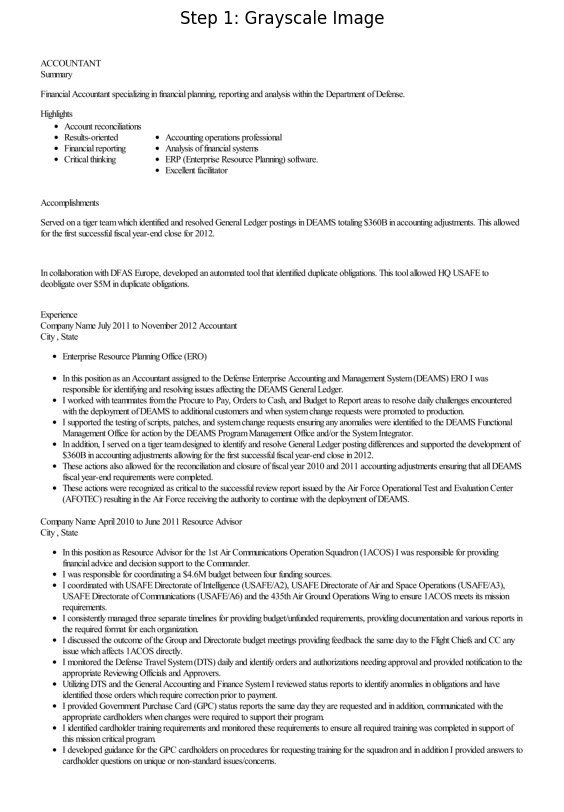

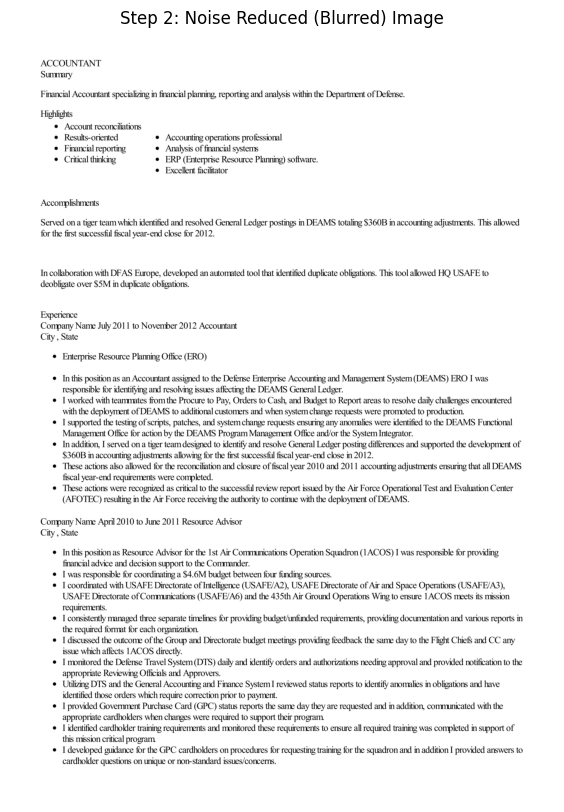

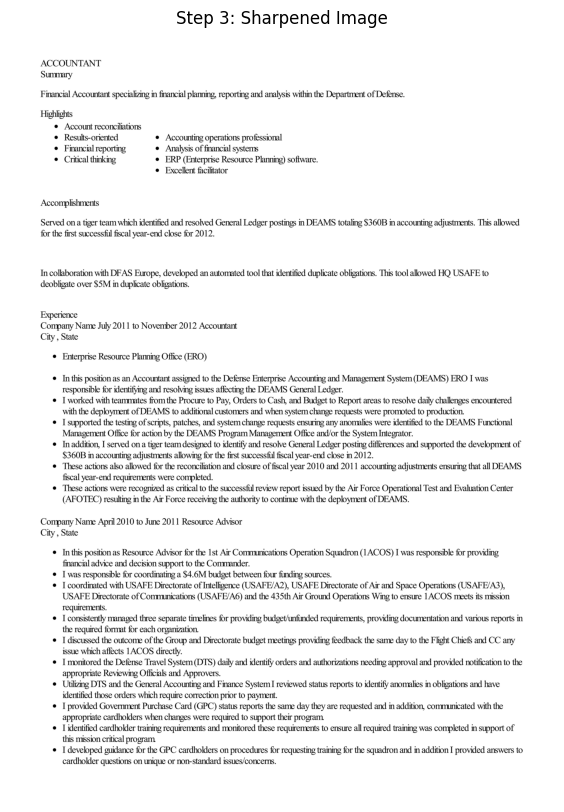

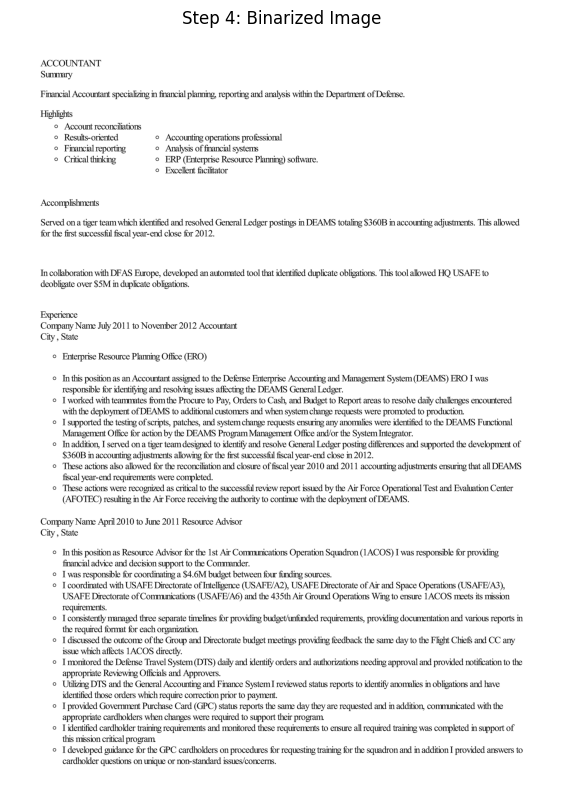

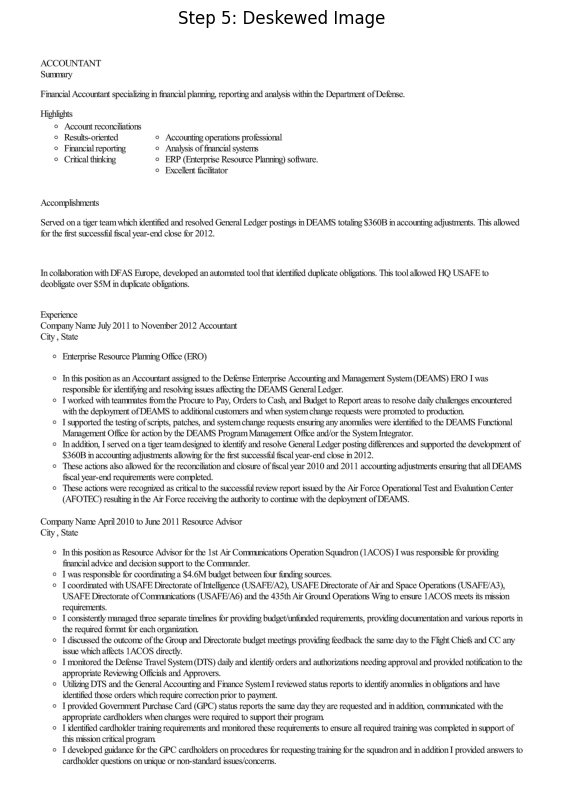

Saved processed image to: /content/processed_resume_pdfs/processed_resume_10554236_page_0.jpg


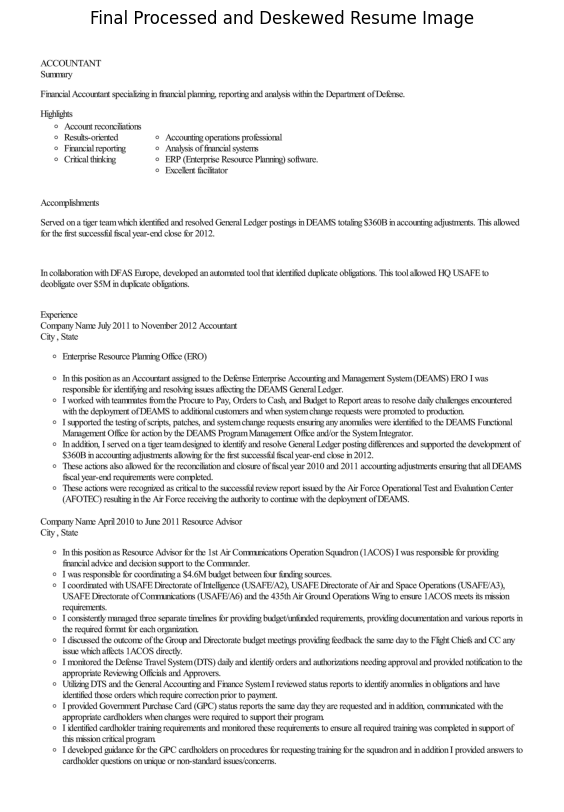


Processing all resume pages completed.
Total time taken: 25.04266381263733 seconds


In [ ]:
###Use this code cell if you want to do image cleaning on the first page
import time
from tqdm.auto import tqdm
import pymupdf # Added import for PyMuPDF here for self-containment

output_folder_path = "/content/processed_resume_pdfs" # Changed to a new folder
start_time = time.time()

# Ensure output folder exists
if not os.path.exists(output_folder_path):
  os.makedirs(output_folder_path)
  print(f"Created folder: {output_folder_path}")

# Redefine one_resume_path and one_image for self-contained execution
# This ensures these variables are always available in this cell's scope
one_resume_path = os.path.join(path, 'data', 'data', 'ACCOUNTANT', '10554236.pdf')

print(f"Processing resume: {one_resume_path}")

# Open the PDF file
doc = pymupdf.open(one_resume_path)

page = doc[0]
# Render page to an image (pixmap) with increased resolution
scale = 8.0
pix = page.get_pixmap(matrix=pymupdf.Matrix(scale, scale))

# Convert pixmap to numpy array
one_image = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)


print(f"\n--- Processing Page ---")
# Process the image with individual step visualization
processed_resume_image = process_and_display_resume_steps(one_image)

# Save the final processed image for this page
output_resume_path = os.path.join(output_folder_path, f"processed_resume_10554236_page_0.jpg")
cv2.imwrite(output_resume_path, processed_resume_image)

##For a single page:
print(f"Saved processed image to: {output_resume_path}")
display_image(processed_resume_image, "Final Processed and Deskewed Resume Image")

doc.close()

print("\nProcessing all resume pages completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

###Extracting Text From a PDF for Information Extraction.

The enhanced images of the pdfs are not clearer than the original pdfs, so I will just be running the pdfs through an LLM to extract information that way. I will also be using the fitness resumes for this.

In [ ]:
! pip install PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
resume_path = os.path.join(path, 'data', 'data')
if os.makedirs(resume_path, exist_ok=True):
  print(f"Created folder: {resume_path}")

###Extracting Text using PyPDF2


In [ ]:
from PyPDF2 import PdfReader

# getting an example text for the prompt
fitness_resumes_path = os.path.join(path, 'data', 'data', 'FITNESS')
reader = PdfReader(os.path.join(fitness_resumes_path, '97123005.pdf'))
print("Extracting the text of the last resume under FITNESS")

text_output_test_folder = "/content/fitness_test_file"
all_pdf_text = ""

# Create the output folder if it doesn't exist
if not os.path.exists(text_output_test_folder):
    os.makedirs(text_output_test_folder)
    print(f"Created folder: {text_output_test_folder}")

 # Loop through all pages in the current PDF
for page_num in range(len(reader.pages)):
    page = reader.pages[page_num]
    print(page.extract_text() +"\n\n")
    all_pdf_text += page.extract_text() + "\n\n" # Add extracted text and a separator

# Define the output filename for the text file
test_txt_filename = '97123005.txt'
output_text_path = os.path.join(text_output_test_folder, test_txt_filename)

# Save the extracted text to a .txt file
with open(output_text_path, 'w', encoding='utf-8') as f:
    f.write(all_pdf_text)
print(f"Saved text to: {output_text_path}")


Extracting the text of the last resume under FITNESS
Created folder: /content/fitness_test_file
GROUP FITNESS INSTRUCTOR
Summary
Seasoned customer service specialist with background in providing advice on diverse customer situations. Results-oriented professional with
diverse background in management and customer service. Dedicated to providing excellent customer service and making operational and
procedural improvements. Talented leader and robust ability to communicate needs and effectively deliver knowledge to staff. Administer strong
teams and efficient systems, positively impacting business growth and downsizing objectives. Attention to details.
Highlights
Client relations specialist
Conflict resolution techniques
Team management
Focused on customer satisfaction
Talent development
Training and development
Recruitment
Skilled multi-tasker
Scheduling
Deadline-oriented
Microsoft software proficiency
Meticulous attention to detail
Accomplishments
Played an instrumental role in increas

In [ ]:
resume_prompt = """
Extract the information from the given PDF.
Information to be extracted: job titles, dates worked at each job title, and 3 to 6 skills.
Always give your response in the following format:
{
    "job titles": ["JOB_TITLE_1", "JOB_TITLE_2", "JOB_TITLE_3"],
    "dates_of_employment_by_job": ["DATE_1", "DATE_2", "DATE_3"],
    "skills": ["SKILL_1", "SKILL_2", "SKILL_3", "SKILL_4"]
}
Also, the text has been extracted from the PDF using PyPDF2.
Use the extracted text as support for extracting information.
If you believe the text extraction is incorrect somewhere, you may correct it yourself and provide corrected information.
Respond with the extracted information only in the specified format.
###Example###
**Input:**


"""

In [ ]:
import os

#adding the fitness test file to the resume prompt as an example
example_text_file_path = '/content/fitness_test_file/97123005.txt'

# Read the content of the text file
with open(example_text_file_path, 'r', encoding='utf-8') as f:
    resume_text_content = f.read()

# Append the resume text content to the base resume_prompt
final_prompt_for_ai = resume_prompt + resume_text_content

# You can print a part of it to see the structure
print("--- Final Prompt (first 500 characters) ---")
print(final_prompt_for_ai[:2000])
print("\n...")

--- Final Prompt (first 500 characters) ---

Extract the information from the given PDF.
Information to be extracted: job titles, dates worked at each job title, and 3 to 6 skills.
Always give your response in the following format:
{
    "job titles": ["JOB_TITLE_1", "JOB_TITLE_2", "JOB_TITLE_3"],
    "dates_of_employment_by_job": ["DATE_1", "DATE_2", "DATE_3"],
    "skills": ["SKILL_1", "SKILL_2", "SKILL_3", "SKILL_4"]
}
Also, the text has been extracted from the PDF using PyPDF2.
Use the extracted text as support for extracting information.
If you believe the text extraction is incorrect somewhere, you may correct it yourself and provide corrected information.
Respond with the extracted information only in the specified format.
###Example###
**Input:**


GROUP FITNESS INSTRUCTOR
Summary
Seasoned customer service specialist with background in providing advice on diverse customer situations. Results-oriented professional with
diverse background in management and customer service. Dedic

In [ ]:
resume_prompt_ex_output = """
 ******Output******
{
    "job titles": ["Group Fitness Instructor", "Senior Customer Service Representative",
     "Customer Service Representative", "Dispatcher/ Customer Service Representative"],
    "dates_of_employment_by_job": ["September 2010 to April 2015", "October 2005 to April 2015",
     "December 2003 to June 2004", "February 2000 to August 2003"],
    "skills": ["Account Management", "Enthusiastic people person", "Advanced problem-solving",
     "Great organizational skills", "Active Learning", "Calendaring"]
}


Here is the resume text:

"""
final_prompt_for_ai += resume_prompt_ex_output

In [ ]:
import os
from PyPDF2 import PdfReader # Ensure PdfReader is imported here if not globally

# Define the output folder for the text files
text_output_folder = "/content/fitness_resume_texts"

# Create the output folder if it doesn't exist
if not os.path.exists(text_output_folder):
    os.makedirs(text_output_folder)
    print(f"Created folder: {text_output_folder}")

# Get a list of all files in the folder
all_files = os.listdir(fitness_resumes_path)

# Sort the files (optional, but ensures consistent 'top 10')
all_files.sort()

# Get the top 10 files
top_10_files = all_files[:10]

print(f"Top 10 files in '{fitness_resumes_path}':")
for i, filename in enumerate(top_10_files):
    full_file_path = os.path.join(fitness_resumes_path, filename)
    print(f"{i+1}. {full_file_path}")
    reader = PdfReader(full_file_path)

    # Initialize an empty string to hold all text from the PDF
    all_pdf_text = ""

    # Loop through all pages in the current PDF
    for page_num in range(len(reader.pages)):
        page = reader.pages[page_num]
        all_pdf_text += page.extract_text() + "\n\n" # Add extracted text and a separator

    # Define the output filename for the text file
    text_filename = filename.replace('.pdf', '.txt')
    output_text_path = os.path.join(text_output_folder, text_filename)

    # Save the extracted text to a .txt file
    with open(output_text_path, 'w', encoding='utf-8') as f:
        f.write(all_pdf_text)
    print(f"Saved text to: {output_text_path}")

    if i == 0:
        print("\nExtracting all text of the first resume under FITNESS\n")
        print(all_pdf_text)
    elif i == 1:
        print("\nExtracting all text of the second resume under FITNESS\n")
    elif i == 2:
        print("\nExtracting all text of the third resume under FITNESS\n")
    else:
        print(f"\nExtracting all text of the {i+1}th resume under FITNESS\n")


Created folder: /content/fitness_resume_texts
Top 10 files in '/root/.cache/kagglehub/datasets/snehaanbhawal/resume-dataset/versions/1/data/data/FITNESS':
1. /root/.cache/kagglehub/datasets/snehaanbhawal/resume-dataset/versions/1/data/data/FITNESS/10235429.pdf
Saved text to: /content/fitness_resume_texts/10235429.txt

Extracting all text of the first resume under FITNESS

FITNESS INSTRUCTOR
Professional Summary
Dynamic, entrepreneurial sales executive with a record of achievement and success driving sales growth in highly competitive markets. Solid
background securing key clients and increasing product distribution to grow market share. Steadfast in building new business, securing customer
loyalty, and developing strong relationships with external business partners. Well organized with a track record that demonstrates self-motivation,
creativity and the initiative to achieve both personal and corporate goals.
Skills
Sales Management
Account Management
Program Management
Client Relation

In [ ]:
from google import genai
from google.colab import userdata # colab only code
from PIL import Image
from PyPDF2 import PdfReader
import os
import json
import time

In [ ]:
genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))
time.sleep(10)

You may have to run the following cell again, if there is a resource error with the Google Gemini API getting called too many times too quickly. Also, it might not run at all if the Gemini API has already be called 20 times.

In [ ]:
import pymupdf # Added import for PyMuPDF


fitness_resumes_path = os.path.join(path, 'data', 'data', 'FITNESS')
text_folder_path = "/content/fitness_resume_texts"
output_folder_path = "/content/fitness_resume_json_output"

start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_resumes = sum(1 for entry in os.scandir(fitness_resumes_path))
print(f"Total resumes in folder: {total_resumes}")

all_files = os.listdir(fitness_resumes_path)

# Sort the files in numerical order
all_files.sort()

# Get the top 10 files
top_10_files = all_files[:10]

for i, resume_name in enumerate(top_10_files, 1):

  print(f"Processing resume {i}/{10}: {resume_name}")

  resume_path = os.path.join(fitness_resumes_path, resume_name)

  # --- PDF to Image Conversion (for visual input to AI) ---
  # This part opens the PDF, renders the first page to an image, and converts it to PIL Image format.
  pdf_image = None # Initialize pdf_image to None
  try:
      with pymupdf.open(resume_path) as doc:
          if len(doc) > 0:
              page = doc[0]  # Get the first page
              scale = 2.0 # Adjust scale for desired image resolution
              pix = page.get_pixmap(matrix=pymupdf.Matrix(scale, scale))
              # Convert pixmap to PIL Image
              pdf_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
          else:
              print(f"Warning: PDF '{resume_name}' has no pages. Skipping image rendering.")
  except Exception as e:
      print(f"Error rendering PDF '{resume_name}' to image: {e}")
  # --- End PDF to Image Conversion ---

  text_path = os.path.join(text_folder_path, resume_name.replace('.pdf', '.txt'))

  print(f"Loading extracted text: {text_path}")
  with open(text_path, "r") as f:
    text = f.read()

  print("Extracting information from resume text and image...")

  current_resume_prompt = final_prompt_for_ai + text

  # Construct contents for multimodal input
  contents = []
  if pdf_image:
      contents.append(pdf_image) # Add the PIL Image object
  contents.append({"text": current_resume_prompt}) # Add the text prompt

  response = genai_client.models.generate_content(model='gemini-2.5-flash', contents=contents)

  usage_metadata = response.usage_metadata

  # Print the different token counts
  # print(f"Input Token Count: {usage_metadata.prompt_token_count}")
  # print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
  # print(f"Output Token Count: {usage_metadata.candidates_token_count}")
  # print(f"Total Token Count: {usage_metadata.total_token_count}")

  extracted_information = json.loads(response.text.replace('```json', '').replace('```', ''))

  output_path = os.path.join(output_folder_path, resume_name.replace(".pdf", ".json"))
  with open(output_path, "w") as f:
    json.dump(extracted_information, f, indent=4)

  print(f"Saved extracted information to {output_path}")
  print("-"*50)
  time.sleep(5)

print("Information Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total resumes in folder: 117
Processing resume 1/10: 10235429.pdf
Loading extracted text: /content/fitness_resume_texts/10235429.txt
Extracting information from resume text and image...


ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 52.121835648s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '52s'}]}}

### How to push a PDF (as an image) to Gemini

In [ ]:
#just an exmample using PIL for reference

#import pymupdf  # PyMuPDF is often imported as fitz
# from PIL import Image
# import os

# # Assuming these variables are already defined from previous cells
# # genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))
# # final_prompt_for_ai = your base prompt string

# # --- Step 1: Define the path to your PDF file ---
# # Using the example PDF path from previous cells
# pdf_to_read_path = os.path.join(path, 'data', 'data', 'FITNESS', '97123005.pdf')

# # --- Step 2: Extract text from the PDF (as you've been doing) ---
# # This text can be used as context/prompt for the model
# text_output_test_folder = "/content/fitness_test_file"
# test_txt_filename = '97123005.txt'
# text_path = os.path.join(text_output_test_folder, test_txt_filename)

# # Ensure the text file exists, or extract it if not (using your existing logic)
# if not os.path.exists(text_path):
#     from PyPDF2 import PdfReader
#     reader = PdfReader(pdf_to_read_path)
#     all_pdf_text = ""
#     for page_num in range(len(reader.pages)):
#         page = reader.pages[page_num]
#         all_pdf_text += page.extract_text() + "\n\n"
#     with open(text_path, 'w', encoding='utf-8') as f:
#         f.write(all_pdf_text)
#     print(f"Extracted and saved text to: {text_path}")

# with open(text_path, 'r', encoding='utf-8') as f:
#     extracted_text_content = f.read()

# # Combine the base prompt with the extracted text for the current PDF
# current_prompt_with_text = final_prompt_for_ai + extracted_text_content

# # --- Step 3: Render the PDF page to an image ---
# pil_image_from_pdf = None
# try:
#     with pymupdf.open(pdf_to_read_path) as doc:
#         if len(doc) > 0:
#             page = doc[0]  # Get the first page (index 0) to render

#             # Adjust scale for desired image resolution (e.g., 2.0 for 2x original DPI)
#             scale_factor = 2.0
#             pix = page.get_pixmap(matrix=pymupdf.Matrix(scale_factor, scale_factor))

#             # Convert pixmap directly to a PIL Image object
#             pil_image_from_pdf = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
#             print(f"Successfully rendered first page of PDF as PIL Image: {pil_image_from_pdf.size}")
#         else:
#             print(f"Warning: PDF '{pdf_to_read_path}' has no pages to render.")
# except Exception as e:
#     print(f"Error rendering PDF '{pdf_to_read_path}' to image: {e}")

# # --- Step 4: Construct the contents list for the Gemini model ---
# contents_for_gemini = []

# # Add the rendered image if it was successfully created
# if pil_image_from_pdf:
#     contents_for_gemini.append(pil_image_from_pdf)

# # Add the text prompt (instructions + extracted text) to the contents
# contents_for_gemini.append({"text": current_prompt_with_text})

# # --- Step 5: Call the Gemini model (if image was rendered and client is available) ---
# if genai_client and pil_image_from_pdf: # Only proceed if image was created and client is initialized
#     print("Sending combined image and text to Gemini model...")
#     response = genai_client.models.generate_content(model='gemini-2.5-flash', contents=contents_for_gemini)

#     print("\n--- Gemini Response ---")
#     print(response.text)
#     # Further processing of response.text into JSON would go here
# elif not pil_image_from_pdf:
#     print("Skipping Gemini call because no image was rendered from the PDF.")
# else:
#     print("GenAI client not initialized or no image rendered. Skipping Gemini call.")